The `WaterNetwork` component uses the America's Water Network to describe how downstream flows depend on upstream flows and withdrawals.

The America's Water Network is described in detail in its [working paper](https://www.overleaf.com/read/gftdkjjkdrsn).  The data contained in the network and its loading are described in the sister [`waternet notebook`](https://github.com/AmericasWater/operational-problem/blob/master/docs/waternet.ipynb).

The component definition is very simple:

In [1]:
using Mimi

@defcomp WaterNetwork begin
    gauges = Index()

    # External
    added = Parameter(index=[gauges, time], unit="1000 m^3") # Water added at node from runoff
    removed = Parameter(index=[gauges, time], unit="1000 m^3") # Water removed from node
    returned = Parameter(index=[gauges, time], unit="1000 m^3") # Water returns to a node from canals

    inflows = Variable(index=[gauges, time], unit="1000 m^3") # Sum of upstream outflows
    outflows = Variable(index=[gauges, time], unit="1000 m^3") # inflow + added - removed + returned
end

WaterNetwork

All of these values are defined for each `gauge`, or node on the river network.  They present a water balance:
$$outflows_i(t) = \sum_{j \in N(i)} inflows_i(t) + added_i(t) - removed_i(t) + returned_i(t)$$

Where $N(i)$ are the neighbors of gauge $i$, where neighbors are defined as the upstream sources of flow.

## Initialization

The `added` parameter is set to the runoff calculated by VIC and loaded in `weather.jl`.

In optimization mode, both the `returned` and `removed` parameters are set by the optimization to satisfy allocation demands.

In simulation mode,
- The `removed` parameter is set to the contents of `data/extraction/withdrawals.jld`, if available.
- The `returned` parameter is set to the contents of `data/extraction/returns.jld`, if available.

The `removed` and `returned` variables are generated by `optimize-surface.jl`, which finds plausible extractions to satisfy USGS demands.

## Optimization

The logic for optimization is complicated by the process of matching canal-based withdrawals to gauge-based flows.  However, aside from this, the entire network follows two simple principes.

- **Withdrawal applied to any gauge withdraws water from all downstream gauges.**
- **Runoff added to any guage increases the allottment at all downstream gauges.**

The following shows these gauge-specific allotments, and some interesting caveats.

First, the allotments take a while to calculate (which they are done by `constraintoffset_waternetwork_outflows(m);` in `optimize.jl` if need be), so they are cached in the file `data/partialhouse2.jld`.

In [2]:
using Mimi
include("../src/linproghouse.jl")

cwro = deserialize(open("../data/partialhouse2.jld", "r"))

LinearProgrammingHall(:WaterNetwork,:outflows,[2.05773e6,4.65942e6,1.37603e6,1.7903e6,8.12372e5,5.38333e6,8.37991e5,6.71506e6,1.32844e6,2.54843e6  …  4.42083e6,4.42083e6,4.42083e6,4.42083e6,4.42083e6,4.42083e6,4.42083e6,4.42083e6,4.42083e6,4.42083e6])

This is a Linear Programming Hall file, used for constraint vectors.

Additional informatino on the gauges is stored in the `waternet.RData` file, generated outside of Julia.

In [3]:
using DataFrames

stations = read_rda("../data/waternet.RData", convertdataframes=true)["network"]

,collection,colid,lat,lon,elev,nextpt,dist
1,rivdis,344,40.5,-124.1,11.0,17555,8646.0
2,rivdis,345,42.58,-124.06,35.0,NA,NA
3,rivdis,346,41.51,-123.96,2.0,18209,8794.0
4,rivdis,347,43.58,-123.56,28.0,19439,671.0
5,rivdis,348,46.93,-123.31,7.0,8278,927.0
6,rivdis,349,44.95,-123.03,32.0,20260,1583.0
7,rivdis,350,46.26,-122.91,6.0,20754,23709.0
8,rivdis,354,40.7,-118.2,1259.0,7462,1163.0
9,rivdis,356,46.43,-117.16,200.0,9293,38087.0
10,rivdis,357,48.18,-117.03,610.0,21929,927.0


Unfortunately, the allotment entries in the optimization problem are neither in the same order (they're in vertex order), nor have all of the entries that are in the water network.

In [4]:
println(nrow(stations))
println(length(cwro.f))

22619
22559


We need to use the `wateridverts` dictionary, which maps from gauge IDs to vertices in the network.

In [5]:
using Graphs

wateridverts = deserialize(open("../data/wateridverts.jld", "r"))
keys(wateridverts)
#waternet = deserialize(open("../data/waternet.jld", "r"))

Base.KeyIterator for a Dict{UTF8String,Graphs.ExVertex} with 22559 entries. Keys:
  "usgs.02456000"
  "junction.13805-dn"
  "junction.11142-up"
  "usgs.03488000"
  "usgs.12113347"
  "junction.13981-up"
  "junction.12762-up"
  "usgs.0214627970"
  "usgs.01396800"
  "usgs.05532000"
  "junction.19865-dn"
  "junction.9399-dn"
  "usgs.03025000"
  "usgs.09067200"
  "usgs.08261000"
  "usgs.04286000"
  "junction.22562-up"
  "junction.7795-dn"
  "usgs.11313472"
  "usgs.14337800"
  "reservoir.2566"
  "junction.12093-dn"
  "junction.14022-up"
  "canal.09528800"
  ⋮

And now we can collect all of the information to produce a map.

In [22]:
lats = []
lons = []
runoff = []
for ii in 1:nrow(stations)
    gaugeid = "$(stations[ii, :collection]).$(stations[ii, :colid])"
    if gaugeid in keys(wateridverts)
        runoff = [runoff; cwro.f[vertex_index(wateridverts[gaugeid])]]
        lats = [lats; stations[ii, :lat]]
        lons = [lons; stations[ii, :lon]]
    end
end

runoff[isna(runoff)] = 0

0

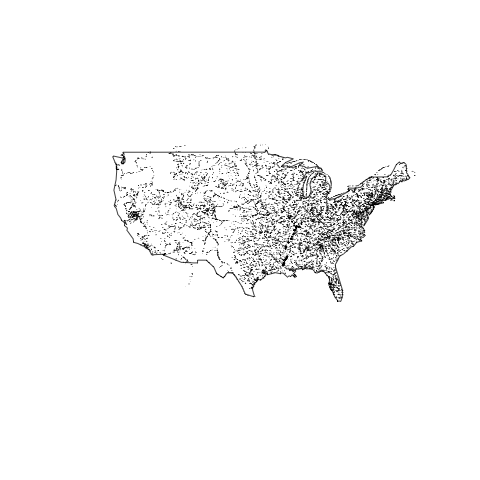

RCall.RObject{RCall.NilSxp}
NULL


In [44]:
using RCall

cex = convert(Vector{Float64}, runoff) / 1e9

R"library(maps)"
R"map('usa', xlim=c(-140, -60), ylim=c(20, 50))"
R"points($lons, $lats, cex=$cex)"